In [60]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tensorflow_addons as tfa
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [61]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [62]:

def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [63]:
def get_uncompiled_model(model_name, model_params_dict):
    assert model_name in ['resnet', 'mscalev2', 'mscalev1', 'mscalev2_custom_scale']

    if model_name == 'resnet':
        model = wispy.resnet.ResNet(**model_params_dict)
    elif model_name == 'mscalev2':
        model = wispy.mscalev2.build_model(**model_params_dict)
    elif model_name == 'mscalev1':
        model = pugna.models.mscalednn.build_model_2(**model_params_dict)
    elif model_name == 'mscalev2_custom_scale':
        model = build_model_custom_scales(**model_params_dict)

    return model


def get_compiled_model(model_name, model_params_dict, extra_params_dict):
    model = get_uncompiled_model(
        model_name=model_name, model_params_dict=model_params_dict)

    optimizer = tf.keras.optimizers.Adam(
        extra_params_dict['lr'], amsgrad=extra_params_dict['amsgrad'])

    model.compile(loss=extra_params_dict['loss'],
                  optimizer=optimizer, metrics=extra_params_dict['metrics'])

    return model

# load data

In [64]:
X_train = np.load('processed_training_data/X_train.npy')
y_train = np.load('processed_training_data/y_train.npy')

X_val = np.load('processed_training_data/X_val.npy')
y_val = np.load('processed_training_data/y_val.npy')

In [65]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")

X_train.shape: (11190, 10)
y_train.shape: (11190, 1)
X_val.shape: (2238, 10)
y_val.shape: (2238, 1)


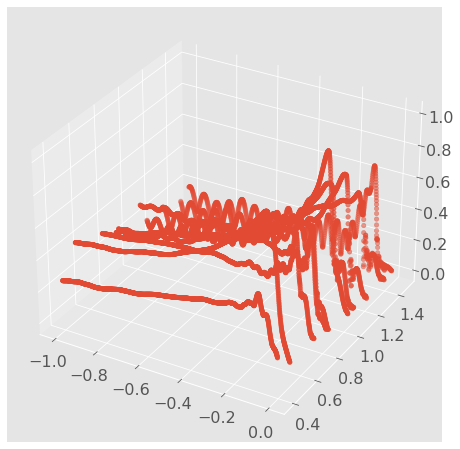

In [66]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,3], y_train[:,0])

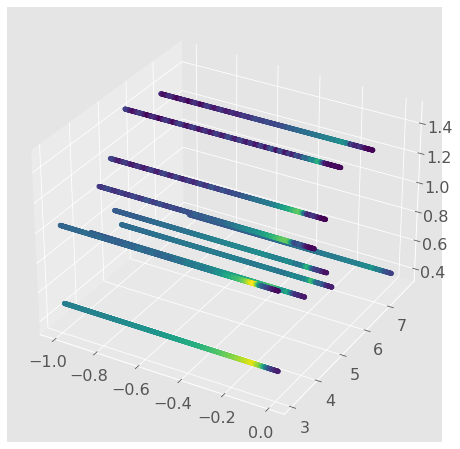

In [67]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,3], c=y_train[:,0])

# multiple waveform test - standard mscale

In [68]:
epochs = 2000
batch_size = X_train.shape[0]
# batch_size = 32
print(f"batch_size: {batch_size}")


# model_name = "mscalev1"

# model_params_dict = dict(
#     input_shape=X_train.shape[1],
#     output_shape=y_train.shape[1],
#     mscale_units = 2048,
#     mscale_activation = 's2relu',
#     nscales = 2048,
#     scale_name = 'linear',
#     units = [256],
#     activation = 's2relu',
#     mscale_bias_initializer = [-0.05, 0.05]
# )


model_name = "mscalev2"

model_params_dict = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units = [128,128,128],
    activation = "s2relu",
    n_blocks = [2,2,2],
    scales = [1,10,100],
    layers_per_block = 3,
)

# model_name = "resnet"

# model_params_dict = dict(
#     input_shape=X_train.shape[1],
#     output_shape=y_train.shape[1],
#     width = 256,
#     num_blocks = 1,
#     group_norm = True,
#     groups = 1,
#     batch_norm = False,
#     momentum = 0.9
# )

extra_params_dict = dict(
    loss = 'mae',
    metrics = ['mse'],
    lr = 1e-3,
    amsgrad = False
)

verbose=0
# callbacks=None
callbacks=[pugna.callbacks.PrintDot()]


sample_weight=None

# t_start = 0.7
# t_end = 1.
# sample_weight = np.ones(len(data_one['X_train']))
# mask = (data_one['X_train'][:, 0] > t_start) & (data_one['X_train'][:, 0] <= t_end)
# sample_weight[mask] = len(sample_weight) * 10000



batch_size: 11190


In [69]:
model = get_compiled_model(
    model_name=model_name,
    model_params_dict=model_params_dict,
    extra_params_dict=extra_params_dict)

In [70]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
scale_layer_5 (ScaleLayer)      (None, 10)           0           input_3[0][0]                    
__________________________________________________________________________________________________
scale_layer_6 (ScaleLayer)      (None, 10)           0           input_3[0][0]                    
__________________________________________________________________________________________________
scale_layer_7 (ScaleLayer)      (None, 10)           0           input_3[0][0]                    
____________________________________________________________________________________________

In [71]:
print("starting fit")
starttime = datetime.datetime.now()
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weight,
    verbose=verbose
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................

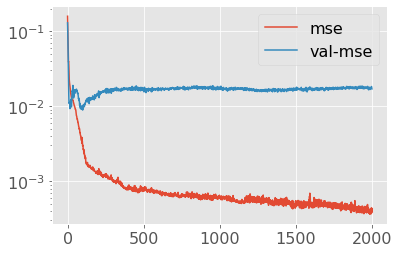

In [72]:
plt.figure()
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='val-mse')
plt.yscale('log')
plt.legend()

In [73]:
yhat = model.predict(X_train)

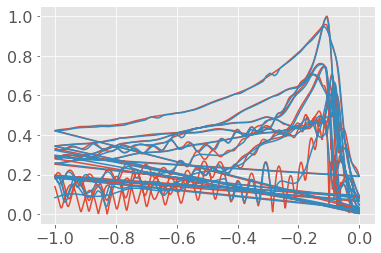

In [74]:
plt.figure()
plt.plot(X_train[:,0], y_train[:,0])
plt.plot(X_train[:,0], yhat[:,0])
# plt.xlim(0.5, 1)

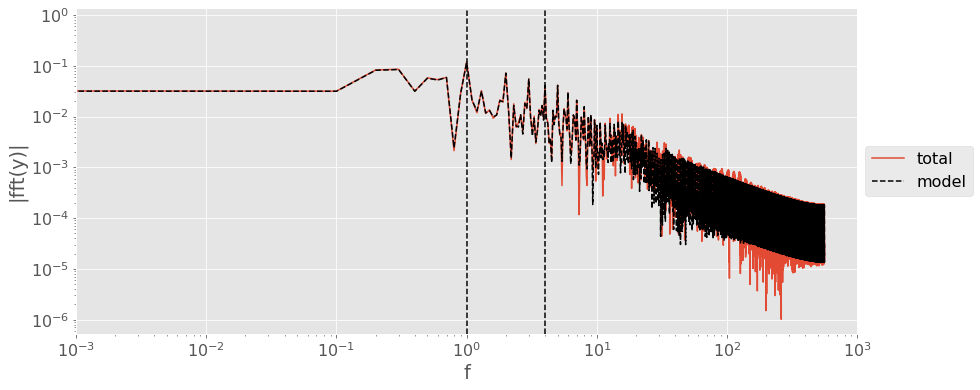

In [75]:
plot_fft(X_train, y_train, model=model, xlim=(1e-3, 1e3), logx=True, logy=True)

# multiple waveform test - modified mscale (scale time only)

# trying single waveform with multiple inputs but separate sub-networks, one for time and other for other

In [76]:
import wispy.mscalev2

In [77]:
inputs = np.array([
    [1,1],
    [2,2],
    [3,3]
])

In [78]:
wispy.mscalev2.ScaleLayer(10)(inputs)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[10, 10],
       [20, 20],
       [30, 30]])>

In [79]:
def make_scale_tensor(input_shape, scale_dimension, scale, dtype):
    scales = np.ones(shape=(input_shape,), dtype=dtype)
    scales[scale_dimension] = scale
    return tf.convert_to_tensor(scales)

In [80]:
make_scale_tensor(inputs.shape[1], 0, 1, dtype=np.float32)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

In [81]:
class ScaleLayer_v2(tf.keras.layers.Layer):
    def __init__(self, scale_tensor, **kwargs):
        super(ScaleLayer_v2, self).__init__()
        self.scale_tensor = scale_tensor

    def call(self, inputs):
        return tf.math.multiply(inputs, self.scale_tensor)

    def get_config(self):
        config = super(ScaleLayer_v2, self).get_config()
        config.update({"scale_tensor": self.scale_tensor})
        return config

In [82]:
inputs.dtype

dtype('int64')

In [83]:
inputs

array([[1, 1],
       [2, 2],
       [3, 3]])

In [84]:
ScaleLayer_v2(make_scale_tensor(input_shape=inputs.shape[1], scale_dimension=0, scale=10, dtype=np.int64))(inputs)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[10,  1],
       [20,  2],
       [30,  3]])>

In [85]:
ScaleLayer_v2(make_scale_tensor(input_shape=inputs.shape[1], scale_dimension=1, scale=10, dtype=np.int64))(inputs)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[ 1, 10],
       [ 2, 20],
       [ 3, 30]])>

In [86]:
import tensorflow as tf
from wispy.mscalev2 import build_subnetwork

In [87]:
def build_model_custom_scales(
    input_shape=1,
    output_shape=1,
    units=[128],
    activation="relu",
    n_blocks=[2],
    scales=[1],
    layers_per_block=3,
    scale_dimension=0,
    dtype=np.float64
):
    """
    scale_dimension=0 means that the first column of X_train will be scaled by `scales`
    and the other dimensions will not be scaled.
    """
    assert (
        len(scales) == len(n_blocks) == len(units)
    ), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, scale in enumerate(scales):
        scale_tensor = make_scale_tensor(input_shape, scale_dimension, scale, dtype=dtype)
        scaled_input = ScaleLayer_v2(scale_tensor)(input_layer)
#         scaled_input = ScaleLayer(scale)(input_layer)
        xs.append(
            build_subnetwork(
                input_tensor=scaled_input,
                units=units[i],
                activation=activation,
                n_blocks=n_blocks[i],
                layers_per_block=layers_per_block,
            )
        )

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(
        output_layer
    )
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [88]:
epochs = 2000
batch_size = X_train.shape[0]
# batch_size = 32
print(f"batch_size: {batch_size}")

model_name = "mscalev2_custom_scale"

model_params_dict = dict(
    input_shape=X_train.shape[1],
    output_shape=y_train.shape[1],
    units = [128,128,128],
    activation = "s2relu",
    n_blocks = [2,2,2],
    scales = [1,10,100],
    layers_per_block = 3,
    scale_dimension = 0,
    dtype = np.float32
)

# model_name = "mscalev1"

# model_params_dict = dict(
#     input_shape=X_train.shape[1],
#     output_shape=y_train.shape[1],
#     mscale_units = 2048,
#     mscale_activation = 's2relu',
#     nscales = 2048,
#     scale_name = 'linear',
#     units = [256],
#     activation = 's2relu',
#     mscale_bias_initializer = [-0.05, 0.05]
# )

# model_name = "mscalev2"

# model_params_dict = dict(
#     input_shape=X_train.shape[1],
#     output_shape=y_train.shape[1],
#     units = [128,128,128],
#     activation = "s2relu",
#     n_blocks = [1,1,3],
#     scales = [1,10,100],
#     layers_per_block = 5
# )

# model_name = "resnet"

# model_params_dict = dict(
#     input_shape=X_train.shape[1],
#     output_shape=y_train.shape[1],
#     width = 256,
#     num_blocks = 1,
#     group_norm = True,
#     groups = 1,
#     batch_norm = False,
#     momentum = 0.9
# )


extra_params_dict = dict(
    loss = 'mae',
    metrics = ['mse'],
    lr = 1e-3,
    amsgrad = False
)

verbose=0
# callbacks=None
callbacks=[pugna.callbacks.PrintDot()]
sample_weight=None

model_v2_custom_scale = get_compiled_model(
    model_name=model_name,
    model_params_dict=model_params_dict,
    extra_params_dict=extra_params_dict)

batch_size: 11190


In [89]:
model_v2_custom_scale.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
scale_layer_v2_9 (ScaleLayer_v2 (None, 10)           0           input_4[0][0]                    
__________________________________________________________________________________________________
scale_layer_v2_10 (ScaleLayer_v (None, 10)           0           input_4[0][0]                    
__________________________________________________________________________________________________
scale_layer_v2_11 (ScaleLayer_v (None, 10)           0           input_4[0][0]                    
____________________________________________________________________________________________

In [90]:
print("starting fit")
starttime = datetime.datetime.now()
history_v2_custom_scale = model_v2_custom_scale.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weight,
    verbose=verbose
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................

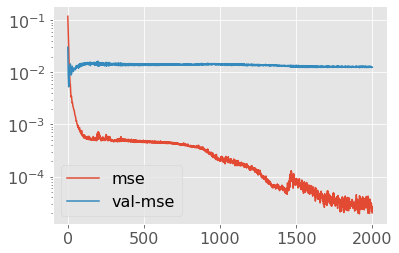

In [91]:
plt.figure()
plt.plot(history_v2_custom_scale.history['mse'], label='mse')
plt.plot(history_v2_custom_scale.history['val_mse'], label='val-mse')
plt.yscale('log')
plt.legend()

In [92]:
yhat_v2_custom_scale = model_v2_custom_scale.predict(X_train)

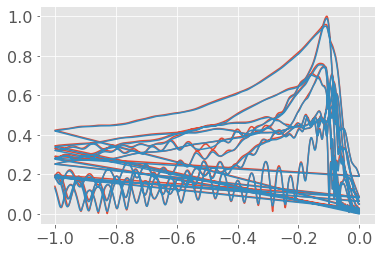

In [93]:
plt.figure()
plt.plot(X_train[:,0], y_train[:,0])
plt.plot(X_train[:,0], yhat_v2_custom_scale[:,0])

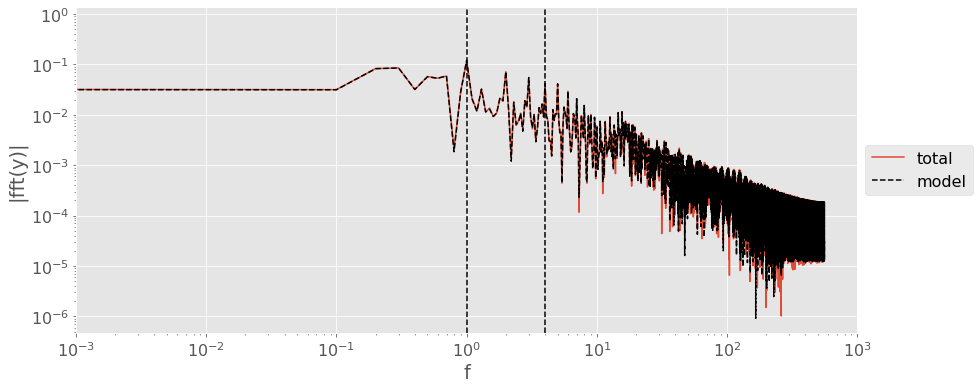

In [94]:
plot_fft(X_train, y_train, model=model_v2_custom_scale, xlim=(1e-3, 1e3), logx=True, logy=True)

# compare

In [112]:
history.history['mse'][-1]

0.0003919638111256063

In [113]:
history_v2_custom_scale.history['mse'][-1]

2.0156476239208132e-05

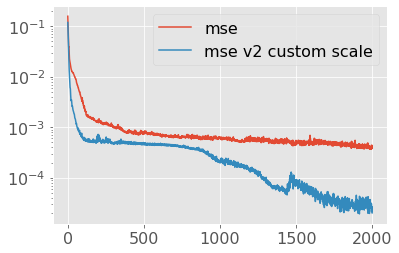

In [95]:
plt.figure()
plt.plot(history.history['mse'], label='mse')
plt.plot(history_v2_custom_scale.history['mse'], label='mse v2 custom scale')
plt.yscale('log')
plt.legend()

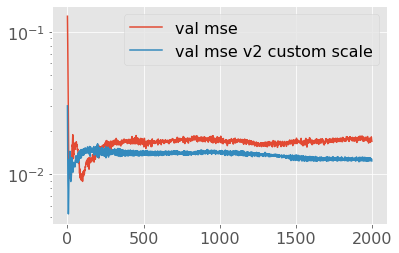

In [106]:
plt.figure()
plt.plot(history.history['val_mse'], label='val mse')
plt.plot(history_v2_custom_scale.history['val_mse'], label='val mse v2 custom scale')
plt.yscale('log')
plt.legend()

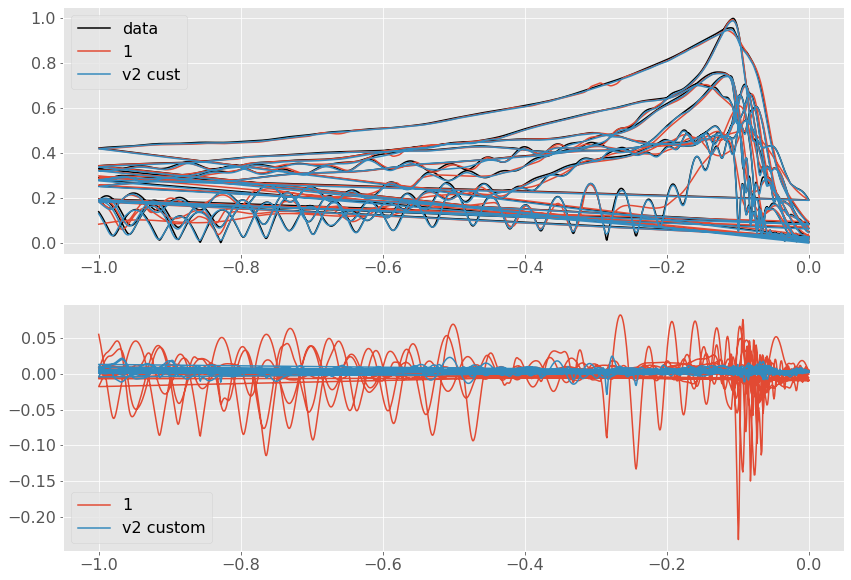

In [105]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.plot(X_train[:,0], y_train[:,0], c='k', label='data')
plt.plot(X_train[:,0], yhat[:,0], label='1')
plt.plot(X_train[:,0], yhat_v2_custom_scale[:,0], label='v2 cust')
# plt.xlim(-0.2, 0)
plt.legend()

plt.subplot(2,1,2)
plt.plot(X_train[:,0], y_train[:,0]-yhat[:,0], label='1')
plt.plot(X_train[:,0], y_train[:,0]-yhat_v2_custom_scale[:,0], label='v2 custom')
plt.legend()